In [52]:
# !pip install torchinfo -q

In [12]:
import torch  # Import PyTorch for deep learning computations
import torchvision  # Import torchvision for pre-trained models and datasets
import torch.nn as nn  # Import neural network module from PyTorch
import torch.optim as optim  # Import optimizers for training models
import time  # Import time module for measuring execution time
import numpy as np  # Import NumPy for numerical operations
import matplotlib.pyplot as plt  # Import Matplotlib for visualization
import os  # Import os for file system operations
import zipfile  # Import zipfile for extracting compressed datasets
import requests  # Import requests for downloading files

import pandas as pd  # Import pandas for data manipulation and analysis
from PIL import Image  # Import PIL for image processing
from torchvision import datasets, models, transforms  # Import datasets, pre-trained models, and transformations from torchvision
from torchinfo import summary  # Import torchinfo for displaying model summaries
from torch.utils.data import DataLoader  # Import DataLoader for handling batch data loading

plt.style.use('ggplot')  # Set the Matplotlib style to 'ggplot' for better visuals

<h1>Download Dataset</h1>

In [6]:
# Helper function to download file.
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)

In [7]:
# Download the dataset.
download_file(
    'https://www.dropbox.com/s/0ltu2bsja3sb2j4/caltech256_subset.zip?dl=1',
    'caltech256_subset.zip'
)

In [8]:
# Extract the dataset.
file = 'caltech256_subset.zip'
with zipfile.ZipFile(file, 'r') as zip:
    # extract all files
    print('extraction...')
    zip.extractall()
    print('Done!')

extraction...
Done!


<h1>Preprocessing Data</h1>

<h3>Preprocessing Transforms</h3>

In [9]:
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # Normalize image using mean
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # Normalize image using mean
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # Normalize image using mean
                             [0.229, 0.224, 0.225])
    ])
}

<h3>Dataset Preparation</h3>

In [11]:
#-------------- Load Data --------------
batch_size = 32
dataset = "caltech256_subset"
train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, "valid")
test_directory = os.path.join(dataset, "test")
num_classes = len(os.listdir(valid_directory))
print(num_classes)

data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test']),
}

idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

train_data_loader = DataLoader(data['train'], batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=batch_size, shuffle=True)

10
{0: 'bear', 1: 'chimp', 2: 'giraffe', 3: 'gorilla', 4: 'llama', 5: 'ostrich', 6: 'porcupine', 7: 'skunk', 8: 'triceratops', 9: 'zebra'}


In [24]:
device_name = "cpu"
if torch.cuda.is_available():
    device_name = "cuda:0"
elif torch.backends.mps.is_available():
    device_name = "mps"
device = torch.device(device_name)

print(f"Number of training samples:   {train_data_size}")
print(f"Number of validation samples: {valid_data_size}"),
print(f"Number of test samples:       {test_data_size}")
device

Number of training samples:   600
Number of validation samples: 100
Number of test samples:       100


device(type='mps')

<h1>Load RestNet50</h1>

In [28]:
resnet50 = models.resnet50(weights="DEFAULT")
resnet50 = resnet50.to(device)


<h3>Set all layers to be freeze initially</h3>

In [29]:
for param in resnet50.parameters():
    param.requires_grad = False

<h3>Unfreeze the final layer of the classifier's head</h3>

In [30]:
# Change the final fully connected layer of resnet50 model for transfer learning
fc_inputs = resnet50.fc.in_features # get number of input features for the final layer

# Define a new fully connected layer with custom architecture for classification
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes),
    nn.LogSoftmax(dim=1)
)

resnet50 = resnet50.to(device)

<h3>Training Configuration</h3>

In [31]:
loss_function = nn.NLLLoss()
learning_rate = 0.01
optimizer = optim.SGD(
    params=resnet50.parameters(), # Optimizing all parameters of the ResNet50 model
    lr=learning_rate,
    momentum=0.9
)

<h3>Model Training</h3>

In [32]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None
    
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # set to training mode
        model.train()
        
        # loss and accuracy whitin epoch
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            
            ret, predictions  = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            train_acc += acc.item() * inputs.size(0)
            print("Batch number: {:03d}, Training Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))
        
            
        
        with torch.no_grad():
            model.eval()
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = loss_criterion(outputs, labels)
                
                valid_loss += loss.item() * inputs.size(0)
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * inputs.size(0)
                print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
        
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch
            torch.save(model, 'best_model.pt')
        
        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size
        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size
        
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
        
        epoch_end = time.time()
                
        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
    
    return model, history, best_epoch



In [22]:
print(summary(resnet50, input_size=(batch_size, 3, 244, 244)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 10]                  --
├─Conv2d: 1-1                            [32, 64, 122, 122]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 122, 122]        (128)
├─ReLU: 1-3                              [32, 64, 122, 122]        --
├─MaxPool2d: 1-4                         [32, 64, 61, 61]          --
├─Sequential: 1-5                        [32, 256, 61, 61]         --
│    └─Bottleneck: 2-1                   [32, 256, 61, 61]         --
│    │    └─Conv2d: 3-1                  [32, 64, 61, 61]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 61, 61]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 61, 61]          --
│    │    └─Conv2d: 3-4                  [32, 64, 61, 61]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 61, 61]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 61, 61]   

In [37]:
# train the model
num_epochs = 25
train_model, history, best_epoch = train_and_validate(resnet50, loss_function, optimizer, num_epochs)

Epoch: 1/25
Batch number: 000, Training Loss: 0.0316, Accuracy: 1.0000
Batch number: 001, Training Loss: 0.0051, Accuracy: 1.0000
Batch number: 002, Training Loss: 0.0431, Accuracy: 1.0000
Batch number: 003, Training Loss: 0.0464, Accuracy: 1.0000
Batch number: 004, Training Loss: 0.0331, Accuracy: 1.0000
Batch number: 005, Training Loss: 0.0278, Accuracy: 1.0000
Batch number: 006, Training Loss: 0.0915, Accuracy: 0.9688
Batch number: 007, Training Loss: 0.0775, Accuracy: 0.9688
Batch number: 008, Training Loss: 0.0368, Accuracy: 1.0000
Batch number: 009, Training Loss: 0.0668, Accuracy: 0.9688
Batch number: 010, Training Loss: 0.0349, Accuracy: 1.0000
Batch number: 011, Training Loss: 0.0189, Accuracy: 1.0000
Batch number: 012, Training Loss: 0.0440, Accuracy: 1.0000
Batch number: 013, Training Loss: 0.0197, Accuracy: 1.0000
Batch number: 014, Training Loss: 0.0298, Accuracy: 1.0000
Batch number: 015, Training Loss: 0.0763, Accuracy: 0.9688
Batch number: 016, Training Loss: 0.0067, Ac

<h3>Plotting the training log</h3>

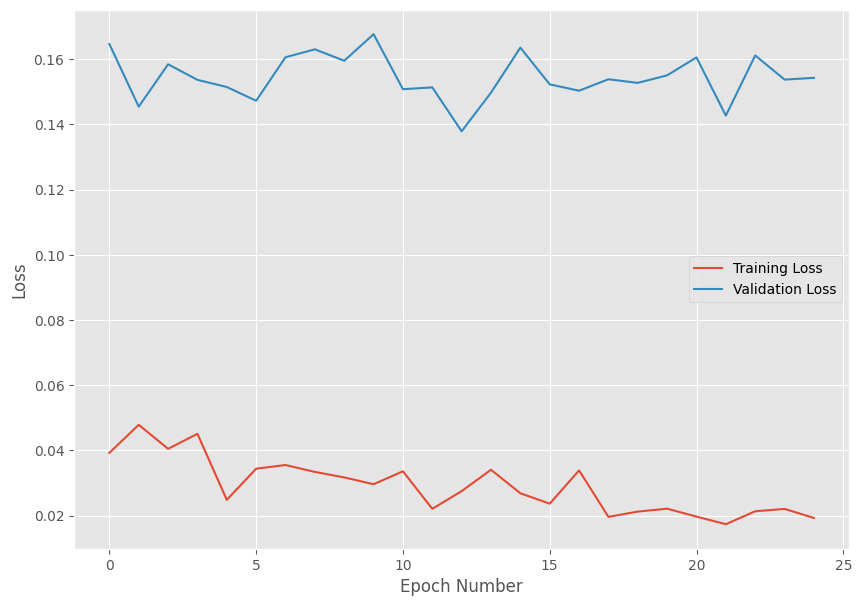

In [38]:
plt.figure(figsize=(10, 7))
history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.savefig('loss_curve.png')
plt.show()

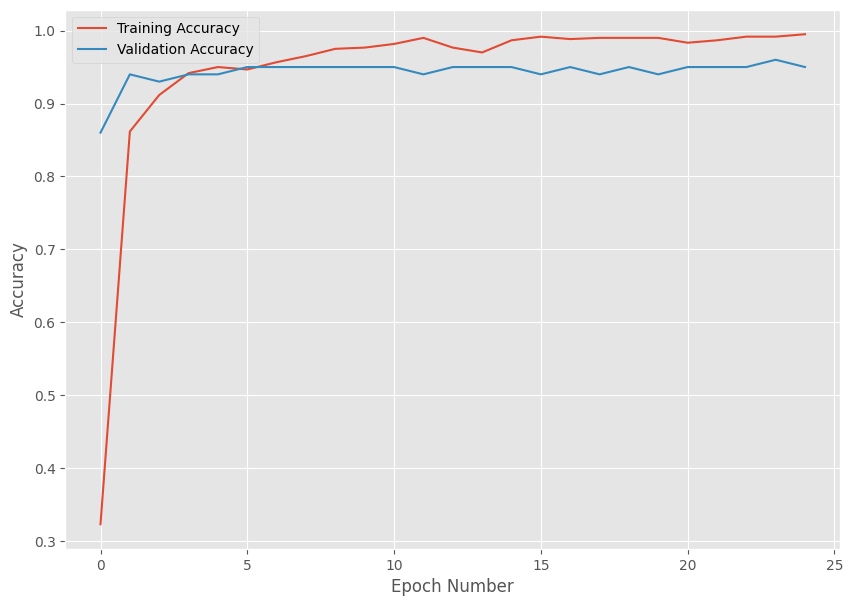

In [ ]:
plt.figure(figsize=(10, 7))
history = np.array(history)
plt.plot(history[:, 2:4])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.savefig('accuracy_curve.png')
plt.show()

In [34]:
def compute_test_accuracy(model, loss_criterion):
    device_name = "cpu"
    if torch.cuda.is_available():
        device_name = "cuda:0"
    elif torch.backends.mps.is_available():
        device_name = "mps"
    device = torch.device(device_name)
    
    test_acc = 0.0
    test_loss = 0.0
    
    with torch.no_grad():
        model.eval()
        
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            test_acc += acc.item() * inputs.size(0)
            print(f"Test Batch number: {j:03d}, Test: Loss: {loss.item():.4f}, Accuracy: {acc.item():.4f}")
    
    avg_test_loss = test_loss/test_data_size
    avg_test_acc = test_acc/test_data_size
    
    print("Test accuracy: {:.4f}".format(avg_test_acc))

In [44]:
model = torch.load("best_model.pt", weights_only=False)
compute_test_accuracy(model, loss_function)

Test Batch number: 000, Test: Loss: 0.0860, Accuracy: 0.9688
Test Batch number: 001, Test: Loss: 0.0922, Accuracy: 0.9688
Test Batch number: 002, Test: Loss: 0.1218, Accuracy: 0.9688
Test Batch number: 003, Test: Loss: 0.0011, Accuracy: 1.0000
Test accuracy: 0.9700


<h1>Inference</h1>

In [49]:
def predict(model, test_image_name):
    transform = image_transforms['test']
    test_image = Image.open(test_image_name)
    plt.figure(figsize=(10, 7))
    plt.axis("off")
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)
    test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.cuda()
    elif torch.backends.mps.is_available():
        test_image_tensor = test_image_tensor.to(torch.device("mps"))
    
    with torch.no_grad():
        model.eval()
        out = model(test_image_tensor)
        ps = torch.exp(out)
        
        topk, topclass = ps.topk(3, dim=1)
        cls = idx_to_class[topclass.cpu().numpy()[0][0]]  # Get the top predicted class
        score = topk.cpu().numpy()[0][0]  # Get the top prediction confidence score

        # Print the top 3 predictions with their confidence scores
        for i in range(3):
            print(f"Prediction {i+1}: {idx_to_class[topclass.cpu().numpy()[0][i]]}",
                  f"Score: {topk.cpu().numpy()[0][i]*100:.3f}%")
    
    

In [46]:
!wget -q "https://learnopencv.com/wp-content/uploads/2022/10/skunk.jpg" -O "skunk.jpg"
!wget -q "https://learnopencv.com/wp-content/uploads/2024/02/Zebra.jpg" -O "Zebra.jpg"
!wget -q "https://learnopencv.com/wp-content/uploads/2024/07/llama-scaled.jpg" -O "llama.jpg"
!wget -q "https://learnopencv.com/wp-content/uploads/2024/07/llama_-scaled.jpg" -O "llama_.jpg"

Prediction 1: skunk Score: 99.936%
Prediction 2: porcupine Score: 0.053%
Prediction 3: chimp Score: 0.004%


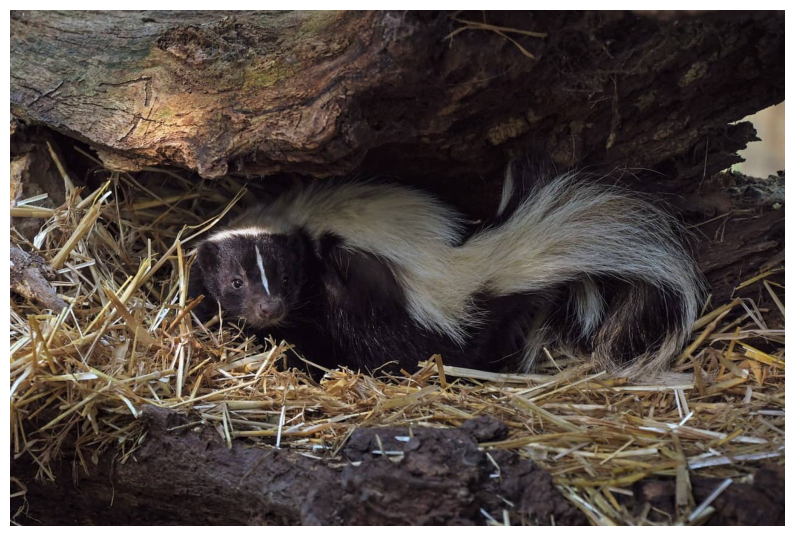

In [51]:
predict(model, "skunk.jpg")

Prediction 1: zebra Score: 99.991%
Prediction 2: giraffe Score: 0.006%
Prediction 3: ostrich Score: 0.001%


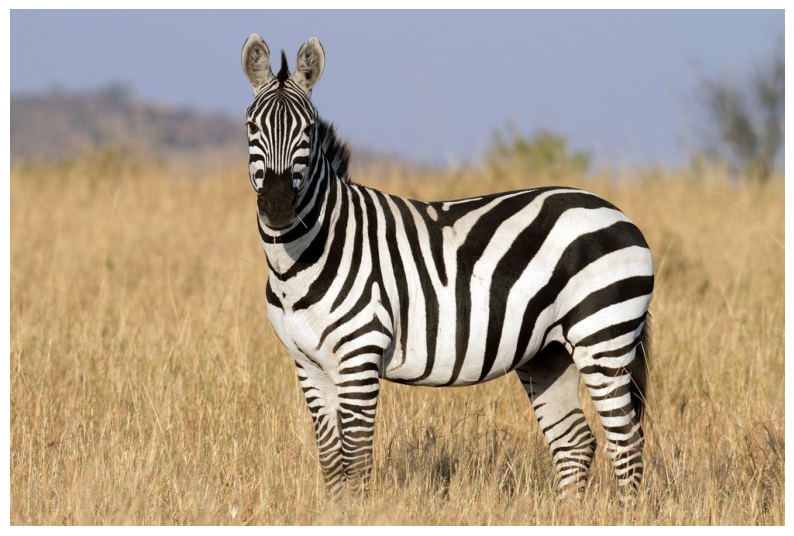

In [52]:
predict(model, "Zebra.jpg")

Prediction 1: bear Score: 35.442%
Prediction 2: llama Score: 25.882%
Prediction 3: chimp Score: 17.150%


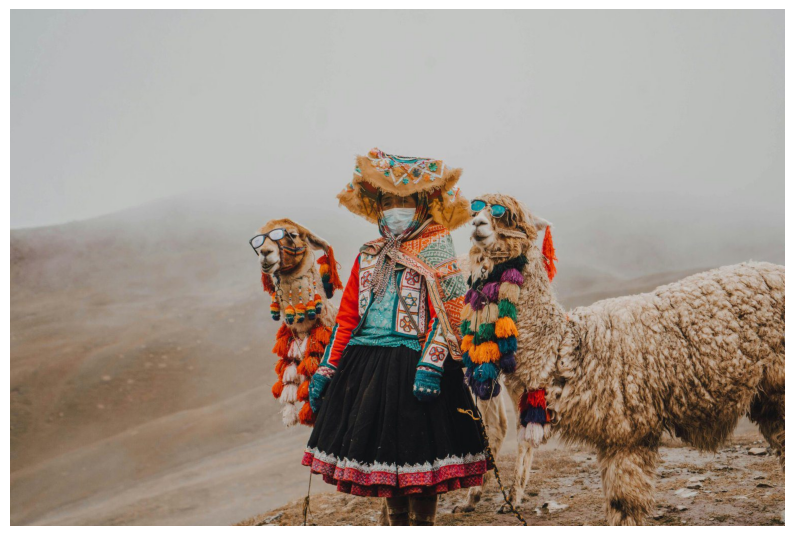

In [53]:
predict(model, "llama.jpg")

Prediction 1: llama Score: 99.969%
Prediction 2: giraffe Score: 0.015%
Prediction 3: bear Score: 0.007%


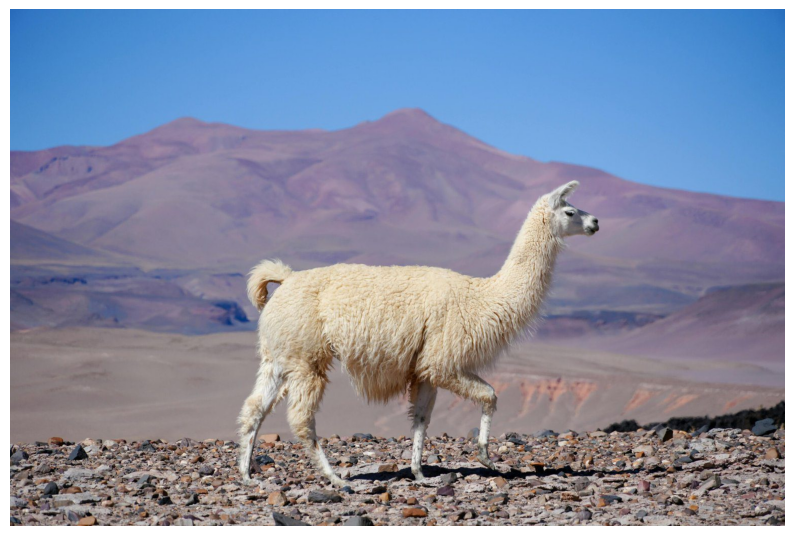

In [54]:
predict(model, 'llama_.jpg')